# Восстановление золота из руды

___
**Описание проекта**  

Подготовьте прототип модели машинного обучения для «Цифры». Компания разрабатывает решения для эффективной работы промышленных предприятий.

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды. Используйте данные с параметрами добычи и очистки. 

Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.
___
**Цель**  

Вам нужно:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.

Чтобы выполнить проект, обращайтесь к библиотекам *pandas*, *matplotlib* и *sklearn.* Вам поможет их документация.
___
**Описание данных:**  

Данные находятся в трёх файлах:  

- `gold_recovery_train_new.csv` — обучающая выборка;  
- `gold_recovery_test_new.csv` — тестовая выборка;  
- `gold_recovery_full_new.csv` — исходные данные.  

Данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи.
Некоторые параметры недоступны, потому что замеряются и/или рассчитываются значительно позже. Из-за этого в тестовой выборке отсутствуют некоторые признаки, которые могут быть в обучающей. Также в тестовом наборе нет целевых признаков.
Исходный датасет содержит обучающую и тестовую выборки со всеми признаками.
В вашем распоряжении сырые данные: их просто выгрузили из хранилища. Прежде чем приступить к построению модели, проверьте по нашей инструкции их на корректность.

*Технологический процесс*  

- `Rougher feed` — исходное сырье  
- `Rougher additions` (или reagent additions) — флотационные реагенты: Xanthate, Sulphate, Depressant  
-     `Xanthate **`— ксантогенат (промотер, или активатор флотации);  
-     `Sulphate` — сульфат (на данном производстве сульфид натрия);  
-     `Depressant` — депрессант (силикат натрия).  
- `Rougher process` (англ. «грубый процесс») — флотация  
- `Rougher tails` — отвальные хвосты  
- `Float banks` — флотационная установка  
- `Cleaner process` — очистка  
- `Rougher Au` — черновой концентрат золота  
- `Final Au` — финальный концентрат золота  
___
**Наименование признаков:**

Наименование признаков должно быть такое:  
[этап].[тип_параметра].[название_параметра]  
Пример: rougher.input.feed_ag  

Возможные значения для блока [этап]:  

- `rougher` — флотация  
- `primary_cleaner` — первичная очистка  
- `secondary_cleaner` — вторичная очистка  
- `final` — финальные характеристики  

Возможные значения для блока [тип_параметра]:  

- `input` — параметры сырья  
- `output` — параметры продукта  
- `state` — параметры, характеризующие текущее состояние этапа  
- `calculation` — расчётные характеристики  

Параметры этапов [название_параметра]  

- `air amount` — объём воздуха  
- `fluid levels` — уровень жидкости  
- `feed size` — размер гранул сырья  
- `feed rate` — скорость подачи  

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Модель" data-toc-modified-id="Модель-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

## Подготовка данных

### Считаем данные из csv-файлов в датафреймы и сохраним в переменные: `df_train`, `df_test`, `df_full`. Пути к файлам:
  
- `/datasets/gold_recovery_train_new.csv`;  
- `/datasets/gold_recovery_test_new.csv`;  
- `/datasets/gold_recovery_full_new.csv`.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from scipy import stats as st

In [2]:
#Инициализация модели дерева решений
from sklearn.tree import DecisionTreeRegressor

#Инициализация модели CatBoost
from catboost import CatBoostRegressor

#Поиск лучших параметров модели
from sklearn.model_selection import GridSearchCV

#Преобразователь масштаба методом стандартизации
from sklearn.preprocessing import StandardScaler

#Проверка модели на адекватность
from sklearn.dummy import DummyRegressor

#Разделение выборки в заданных пропорциях
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.metrics import f1_score, roc_auc_score, roc_curve, precision_score, recall_score

from sklearn.metrics import precision_recall_curve, accuracy_score, mean_absolute_error, make_scorer

from sklearn.utils import shuffle

import re

#Сохранение и загрузка обученной модели
import joblib

In [3]:
try:
    df_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
    df_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')
    df_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
except:
    print('File_not_found')

### Изучим общую информацию о полученных датафреймах

**Добавим настройки для удобства отображения данных**

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)
pd.options.display.float_format = '{:,.4f}'.format

#Если необходимо вернуть дефолтные настройки, раскомментируй строку ниже
#pd.reset_option('all')

**Выведем первые 10 строчек датафреймов `df_train`, `df_test`, `df_full` на экран.**

In [5]:
df_train.head(10).T

,0,1,2,3,4,5,6,7,8,9
date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00,2016-01-15 05:00:00,2016-01-15 06:00:00,2016-01-15 07:00:00,2016-01-15 08:00:00,2016-01-15 09:00:00
final.output.concentrate_ag,6.0554,6.0294,6.0559,6.0480,6.1486,6.4830,6.5338,6.1308,5.8341,5.6871
final.output.concentrate_pb,9.8896,9.9689,10.2140,9.9770,10.1425,10.0494,10.0581,9.9355,10.0712,9.9804
final.output.concentrate_sol,5.5073,5.2578,5.3838,4.8586,4.9394,5.4803,4.5691,4.3898,4.8764,5.2825
final.output.concentrate_au,42.1920,42.7016,42.6575,42.6898,42.7741,41.6337,41.9953,42.4527,43.4041,43.2352
final.output.recovery,70.5412,69.2662,68.1164,68.3475,66.9270,69.4658,69.3008,70.2310,69.6886,70.2796
final.output.tail_ag,10.4120,10.4627,10.5070,10.4228,10.3603,10.1827,10.3046,10.4433,10.4201,10.4870
final.output.tail_pb,0.8954,0.9275,0.9537,0.8838,0.7928,0.6641,0.8073,0.9493,1.0655,1.1598
final.output.tail_sol,16.9043,16.6345,16.2088,16.5328,16.5257,16.9996,16.7236,16.6900,17.2019,17.4840
final.output.tail_au,2.1431,2.2249,2.2579,2.1468,2.0553,1.9186,2.0589,2.1434,2.2099,2.2096


In [6]:
df_test.head(10).T

,0,1,2,3,4,5,6,7,8,9
date,2016-09-01 00:59:59,2016-09-01 01:59:59,2016-09-01 02:59:59,2016-09-01 03:59:59,2016-09-01 04:59:59,2016-09-01 05:59:59,2016-09-01 06:59:59,2016-09-01 07:59:59,2016-09-01 08:59:59,2016-09-01 09:59:59
primary_cleaner.input.sulfate,210.8009,215.3925,215.2599,215.3362,199.0993,168.4851,144.1334,133.5134,133.7354,126.9611
primary_cleaner.input.depressant,14.9931,14.9875,12.8849,12.0068,10.6825,8.8170,7.9246,8.0553,7.9996,8.0179
primary_cleaner.input.feed_size,8.0800,8.0800,7.7867,7.6400,7.5300,7.4200,7.4200,6.9880,6.9350,7.0300
primary_cleaner.input.xanthate,1.0050,0.9905,0.9960,0.8635,0.8056,0.7912,0.7888,0.8019,0.7893,0.8053
primary_cleaner.state.floatbank8_a_air,"1,398.9813","1,398.7779","1,398.4937","1,399.6181","1,401.2681","1,402.8268","1,398.2524","1,401.6697","1,402.3590","1,400.8161"
primary_cleaner.state.floatbank8_a_level,-500.2256,-500.0574,-500.8684,-498.8636,-500.8083,-499.2995,-499.7487,-501.7778,-499.9816,-499.0142
primary_cleaner.state.floatbank8_b_air,"1,399.1449","1,398.0554","1,398.8604","1,397.4401","1,398.1288","1,401.5111","1,393.2555","1,400.7544","1,400.9860","1,399.9754"
primary_cleaner.state.floatbank8_b_level,-499.9197,-499.7782,-499.7645,-499.2110,-499.5045,-499.2054,-499.1954,-502.5140,-496.8030,-499.5706
primary_cleaner.state.floatbank8_c_air,"1,400.1030","1,396.1510","1,398.0757","1,400.1293","1,402.1722","1,404.0881","1,396.7386","1,400.4652","1,401.1686","1,401.8719"


In [7]:
df_full.head(10).T

,0,1,2,3,4,5,6,7,8,9
date,2016-01-15 00:00:00,2016-01-15 01:00:00,2016-01-15 02:00:00,2016-01-15 03:00:00,2016-01-15 04:00:00,2016-01-15 05:00:00,2016-01-15 06:00:00,2016-01-15 07:00:00,2016-01-15 08:00:00,2016-01-15 09:00:00
final.output.concentrate_ag,6.0554,6.0294,6.0559,6.0480,6.1486,6.4830,6.5338,6.1308,5.8341,5.6871
final.output.concentrate_pb,9.8896,9.9689,10.2140,9.9770,10.1425,10.0494,10.0581,9.9355,10.0712,9.9804
final.output.concentrate_sol,5.5073,5.2578,5.3838,4.8586,4.9394,5.4803,4.5691,4.3898,4.8764,5.2825
final.output.concentrate_au,42.1920,42.7016,42.6575,42.6898,42.7741,41.6337,41.9953,42.4527,43.4041,43.2352
final.output.recovery,70.5412,69.2662,68.1164,68.3475,66.9270,69.4658,69.3008,70.2310,69.6886,70.2796
final.output.tail_ag,10.4120,10.4627,10.5070,10.4228,10.3603,10.1827,10.3046,10.4433,10.4201,10.4870
final.output.tail_pb,0.8954,0.9275,0.9537,0.8838,0.7928,0.6641,0.8073,0.9493,1.0655,1.1598
final.output.tail_sol,16.9043,16.6345,16.2088,16.5328,16.5257,16.9996,16.7236,16.6900,17.2019,17.4840
final.output.tail_au,2.1431,2.2249,2.2579,2.1468,2.0553,1.9186,2.0589,2.1434,2.2099,2.2096


**Посмотрим на размер данных (количество строк, колонок).**

In [8]:
print(f'\nКоличество строк: {df_train.shape[0]}\nКоличество колонок: {df_train.shape[1]}\n')


Количество строк: 14149
Количество колонок: 87



In [9]:
print(f'\nКоличество строк: {df_test.shape[0]}\nКоличество колонок: {df_test.shape[1]}\n')


Количество строк: 5290
Количество колонок: 53



In [10]:
print(f'\nКоличество строк: {df_full.shape[0]}\nКоличество колонок: {df_full.shape[1]}\n')


Количество строк: 19439
Количество колонок: 87



**Просмотрим статистическую сводку каждой колонки, чтобы узнать распределение данных в каждой колонки. Используем метод `describe()`.**

In [11]:
df_train.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,14149,14149,2016-04-19 23:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
final.output.concentrate_ag,"14,148.0000",NaN,NaN,NaN,5.1420,1.3696,0.0000,4.2116,4.9947,5.8595,16.0019
final.output.concentrate_pb,"14,148.0000",NaN,NaN,NaN,10.1330,1.6549,0.0000,9.2974,10.2971,11.1706,17.0319
final.output.concentrate_sol,"13,938.0000",NaN,NaN,NaN,9.2028,2.7905,0.0000,7.4846,8.8455,10.4875,18.1249
final.output.concentrate_au,"14,149.0000",NaN,NaN,NaN,44.0038,4.9053,0.0000,43.2761,44.8724,46.1664,52.7566
final.output.recovery,"14,149.0000",NaN,NaN,NaN,66.5188,10.2954,0.0000,62.5458,67.4328,72.3464,100.0000
final.output.tail_ag,"14,149.0000",NaN,NaN,NaN,9.6070,2.3191,0.0000,7.9974,9.4803,11.0037,19.5521
final.output.tail_pb,"14,049.0000",NaN,NaN,NaN,2.5973,0.9718,0.0000,1.9060,2.5920,3.2417,5.6396
final.output.tail_sol,"14,144.0000",NaN,NaN,NaN,10.5121,3.0036,0.0000,8.8113,10.5146,11.9330,22.3177
final.output.tail_au,"14,149.0000",NaN,NaN,NaN,2.9184,0.9037,0.0000,2.3686,2.8510,3.4348,8.1974


In [12]:
df_test.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,5290,5290,2016-11-13 00:59:59,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
primary_cleaner.input.sulfate,"5,286.0000",NaN,NaN,NaN,174.8397,43.0271,2.5662,147.1214,177.8285,208.1254,265.9831
primary_cleaner.input.depressant,"5,285.0000",NaN,NaN,NaN,8.6836,3.0721,0.0038,6.4896,8.0522,10.0278,40.0000
primary_cleaner.input.feed_size,"5,290.0000",NaN,NaN,NaN,7.2663,0.6102,5.6500,6.8900,7.2500,7.6000,15.5000
primary_cleaner.input.xanthate,"5,286.0000",NaN,NaN,NaN,1.3838,0.6435,0.0050,0.9076,1.1976,1.7978,4.1025
primary_cleaner.state.floatbank8_a_air,"5,290.0000",NaN,NaN,NaN,"1,539.4943",116.7979,0.0000,"1,498.9358","1,585.1291","1,602.0765","2,103.1036"
primary_cleaner.state.floatbank8_a_level,"5,290.0000",NaN,NaN,NaN,-497.6659,19.9524,-795.3163,-500.3573,-499.9692,-499.5690,-57.1954
primary_cleaner.state.floatbank8_b_air,"5,290.0000",NaN,NaN,NaN,"1,545.1742",122.2246,0.0000,"1,498.9710","1,595.6218","1,602.3235","1,813.0837"
primary_cleaner.state.floatbank8_b_level,"5,290.0000",NaN,NaN,NaN,-500.2731,32.9683,-799.9970,-500.7030,-500.0285,-499.2933,-142.5272
primary_cleaner.state.floatbank8_c_air,"5,290.0000",NaN,NaN,NaN,"1,527.2724",122.5380,0.0000,"1,473.2299","1,549.5947","1,601.1438","1,715.0538"


In [13]:
df_full.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
date,19439,19439,2016-04-19 23:00:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
final.output.concentrate_ag,"19,438.0000",NaN,NaN,NaN,5.1685,1.3723,0.0000,4.2512,5.0661,5.8955,16.0019
final.output.concentrate_pb,"19,438.0000",NaN,NaN,NaN,9.9789,1.6692,0.0000,9.1373,10.1024,11.0358,17.0319
final.output.concentrate_sol,"19,228.0000",NaN,NaN,NaN,9.5012,2.7875,0.0000,7.7228,9.2190,10.9478,19.6157
final.output.concentrate_au,"19,439.0000",NaN,NaN,NaN,44.0765,5.1298,0.0000,43.4022,45.0112,46.2753,52.7566
final.output.recovery,"19,439.0000",NaN,NaN,NaN,67.0502,10.1258,0.0000,63.2997,68.1727,72.6866,100.0000
final.output.tail_ag,"19,438.0000",NaN,NaN,NaN,9.6886,2.3286,0.0000,8.0629,9.7436,11.1343,19.5521
final.output.tail_pb,"19,338.0000",NaN,NaN,NaN,2.7058,0.9491,0.0000,2.0401,2.7487,3.3332,5.8042
final.output.tail_sol,"19,433.0000",NaN,NaN,NaN,10.5837,2.8688,0.0000,8.9389,10.6225,12.1043,22.3177
final.output.tail_au,"19,439.0000",NaN,NaN,NaN,3.0425,0.9228,0.0000,2.4611,2.9849,3.5714,8.2450


**Выведем основную информацию о датафрейме с помощью метода `info()`.**

In [14]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [15]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [16]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


**Выведем количество пропущенных значений для каждой колонки.**

In [17]:
pd.DataFrame(df_train.isna().sum()).style.background_gradient('coolwarm')

,0
date,0
final.output.concentrate_ag,1
final.output.concentrate_pb,1
final.output.concentrate_sol,211
final.output.concentrate_au,0
final.output.recovery,0
final.output.tail_ag,0
final.output.tail_pb,100
final.output.tail_sol,5
final.output.tail_au,0


In [18]:
pd.DataFrame(df_test.isna().sum()).style.background_gradient('coolwarm')

,0
date,0
primary_cleaner.input.sulfate,4
primary_cleaner.input.depressant,5
primary_cleaner.input.feed_size,0
primary_cleaner.input.xanthate,4
primary_cleaner.state.floatbank8_a_air,0
primary_cleaner.state.floatbank8_a_level,0
primary_cleaner.state.floatbank8_b_air,0
primary_cleaner.state.floatbank8_b_level,0
primary_cleaner.state.floatbank8_c_air,0


In [19]:
pd.DataFrame(df_full.isna().sum()).style.background_gradient('coolwarm')

,0
date,0
final.output.concentrate_ag,1
final.output.concentrate_pb,1
final.output.concentrate_sol,211
final.output.concentrate_au,0
final.output.recovery,0
final.output.tail_ag,1
final.output.tail_pb,101
final.output.tail_sol,6
final.output.tail_au,0


**Выведем пропущенные значения в процентном соотношении.**

In [20]:
pd.DataFrame(df_train.isna().mean()).style.format("{:.2%}").background_gradient('coolwarm')

,0
date,0.00%
final.output.concentrate_ag,0.01%
final.output.concentrate_pb,0.01%
final.output.concentrate_sol,1.49%
final.output.concentrate_au,0.00%
final.output.recovery,0.00%
final.output.tail_ag,0.00%
final.output.tail_pb,0.71%
final.output.tail_sol,0.04%
final.output.tail_au,0.00%


In [21]:
pd.DataFrame(df_test.isna().mean()).style.format("{:.2%}").background_gradient('coolwarm')

,0
date,0.00%
primary_cleaner.input.sulfate,0.08%
primary_cleaner.input.depressant,0.09%
primary_cleaner.input.feed_size,0.00%
primary_cleaner.input.xanthate,0.08%
primary_cleaner.state.floatbank8_a_air,0.00%
primary_cleaner.state.floatbank8_a_level,0.00%
primary_cleaner.state.floatbank8_b_air,0.00%
primary_cleaner.state.floatbank8_b_level,0.00%
primary_cleaner.state.floatbank8_c_air,0.00%


In [22]:
pd.DataFrame(df_full.isna().mean()).style.format("{:.2%}").background_gradient('coolwarm')

,0
date,0.00%
final.output.concentrate_ag,0.01%
final.output.concentrate_pb,0.01%
final.output.concentrate_sol,1.09%
final.output.concentrate_au,0.00%
final.output.recovery,0.00%
final.output.tail_ag,0.01%
final.output.tail_pb,0.52%
final.output.tail_sol,0.03%
final.output.tail_au,0.00%


**Проверим дубликаты.**

In [23]:
df_train.duplicated().sum()

0

In [24]:
df_test.duplicated().sum()

0

In [25]:
df_full.duplicated().sum()

0

### Проверим формулу вычисления эффективности обогащения

- Проверим, что эффективность обогащения рассчитана правильно.
- Вычислим её на обучающей выборке для признака rougher.output.recovery.
- Найдём MAE между вашими расчётами и значением признака.
- Опишем выводы.

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mspace linebreak="newline"></mspace>
  <mi>R</mi>
  <mi>e</mi>
  <mi>c</mi>
  <mi>o</mi>
  <mi>v</mi>
  <mi>e</mi>
  <mi>r</mi>
  <mi>y</mi>
  <mo>=</mo>
  <mfrac>
    <mrow>
      <mi>C</mi>
      <mo>&#x2217;</mo>
      <mo stretchy="false">(</mo>
      <mi>F</mi>
      <mo>&#x2212;</mo>
      <mi>T</mi>
      <mo stretchy="false">)</mo>
    </mrow>
    <mrow>
      <mi>F</mi>
      <mo>&#x2217;</mo>
      <mo stretchy="false">(</mo>
      <mi>C</mi>
      <mo>&#x2212;</mo>
      <mi>T</mi>
      <mo stretchy="false">)</mo>
    </mrow>
  </mfrac>
  <mo>&#x2217;</mo>
  <mn>100</mn>
  <mi mathvariant="normal">%</mi>
</math>

In [26]:
#Функция, рассчитывающая эффективность обогащения

def get_recovery(C, F, T):
    return 100 * (C*(F-T)) / (F*(C-T))

#Где:
#    C — доля золота в концентрате после флотации/очистки;
#    F — доля золота в сырье/концентрате до флотации/очистки;
#    T — доля золота в отвальных хвостах после флотации/очистки.


Cтолбцы, содержащие необходимые значения:

- C - `rougher.output.concentrate_au`
- F - `rougher.input.feed_au`
- T - `rougher.output.tail_au`


**Найдём MAE**

In [27]:
mean_absolute_error(df_train['rougher.output.recovery'].dropna(axis = 0),
                    get_recovery(C = df_train['rougher.output.concentrate_au'].dropna(axis = 0),
                                 F = df_train['rougher.input.feed_au'].dropna(axis = 0),
                                 T = df_train['rougher.output.tail_au'].dropna(axis = 0)))

1.1131451184435918e-14

**Вывод:**  
- MAE имеет очень малое отклонение - это значит, что расчетное значение `rougher.output.recovery` совпадает с данными из столбца, следовательно, эффективность обогащения рассчитана верно.

### Проанализируем признаки, недоступные в тестовой выборке

In [28]:
[col for col in list(df_train.columns) if (col not in list(df_test.columns))]

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'final.output.tail_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'primary_cleaner.output.tail_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.au_pb_ratio',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_pb',
 'rougher.output.ta

**Вывод:**  
- В тестовой выборке отсутствуют выходные параметры продукта output на каждом этапе техпроцесса. Это концентраты и "отвальные хвосты" для металлов (Au, Ag, Pb) и солей, а также рассчитанное recovery на разных этапах. Эти данные в любом случае не подходят для тренировки модели, так как появляются во время или после измерения целевых признаков.
- Также в тестовой выборке отсутствуют расчётные признаки на этапе флотации rougher.calculation (концентрация сульфатов относительно золота, соотношение золота и свинца, и др.).
- Данные признаки не будут участвовать в построении модели.
- При этом столбцы final.output.recovery и rougher.output.recovery являются целевыми, следовательно, их нужно как-то скопировать в тестовую выборку

### Проведём предобработку данных

**Преобразуем тип данных в столбцах date в тип datetime**

In [29]:
df_train['date'] = pd.to_datetime(df_train['date'], format='%Y-%m-%d %H:%M:%S')
df_test['date'] = pd.to_datetime(df_test['date'], format='%Y-%m-%d %H:%M:%S')
df_full['date'] = pd.to_datetime(df_full['date'], format='%Y-%m-%d %H:%M:%S')

**Очистим пропуски путём их удаления**

In [30]:
df_train_original = df_train.copy()

In [31]:
df_train = df_train.dropna()

In [32]:
df_test = df_test.dropna()

In [33]:
df_train.shape[0]

11017

In [34]:
df_test.shape[0]

5229

**Выводы:**

- Данные успешно загружены и проанализированы. Данные соответствуют описанию, дубликатов нет.
- Показатель эффективности обогащения рассчитан корректно.
- Пропуски очищены путём их удаления.

## Анализ данных

### Исследуем изменение концентрации элементов на каждом этапе

**Список стадий**

In [35]:
STAGES = ['rougher.input.feed',
          'rougher.output.concentrate',
          'primary_cleaner.output.concentrate',
          'final.output.concentrate']

**Список елементов**

In [36]:
ELEMENTS = ['au', 'pb', 'ag']

**Гистограммы концентрации вещества по стадиям для списка элементов:**

In [37]:
def display_hist(df, element):
    df.plot.hist(bins=100, alpha=0.5)
    plt.title(f'Суммарная концентрация {element} на разных стадиях')
    plt.legend(['Сырье', 'Черновой концентрат', 'Первичная очистка', 'Финальный концентрат'])
    plt.show()

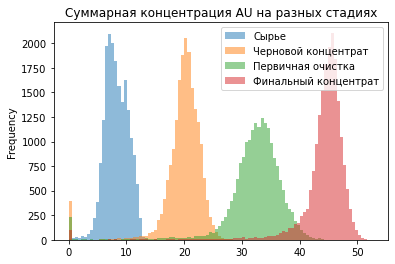

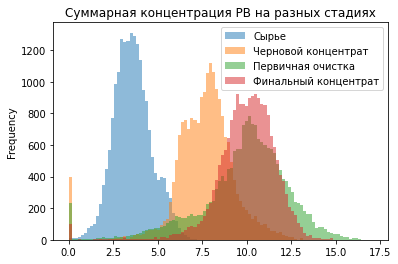

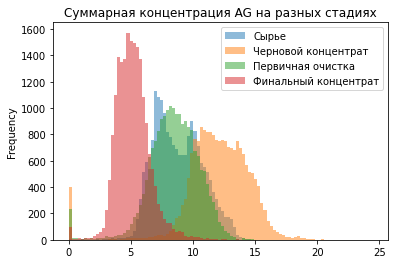

In [38]:
for element in ELEMENTS:
    columns = []
    for stage in STAGES:
        columns.append(stage+'_'+element)
        
    display_hist(df_full[columns], element.upper())

Text(0.5, 0.98, 'Изменение концентрации металлов на различных этапах очистки')

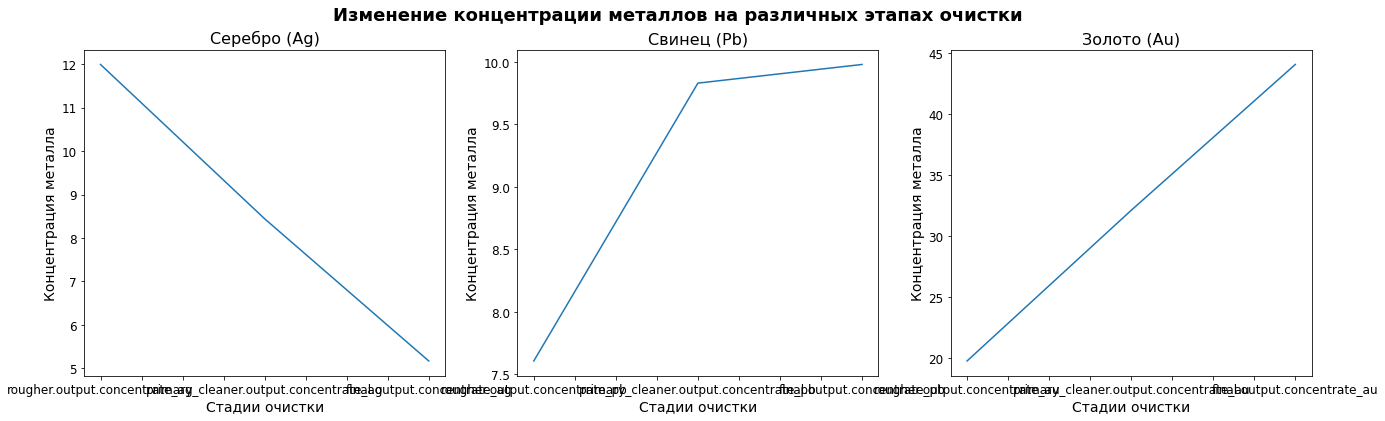

In [39]:
#построим графики для каждого металла.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, linewidth=3, figsize=(22, 6))#1 ряд, 3 графика

df_full[['rougher.output.concentrate_ag', 
              'primary_cleaner.output.concentrate_ag', 
              'final.output.concentrate_ag']].mean().plot(ax=ax1, subplots=True, fontsize=12)
ax1.set_title('Серебро (Ag)', fontsize=16)
ax1.set_ylabel('Концентрация металла', fontsize=14)
ax1.set_xlabel('Стадии очистки', fontsize=14)

df_full[['rougher.output.concentrate_pb', 
              'primary_cleaner.output.concentrate_pb', 
              'final.output.concentrate_pb']].mean().plot(ax=ax2, subplots=True, fontsize=12)
ax2.set_title('Свинец (Pb)', fontsize=16)
ax2.set_ylabel('Концентрация металла', fontsize=14)
ax2.set_xlabel('Стадии очистки', fontsize=14)

df_full[['rougher.output.concentrate_au', 
              'primary_cleaner.output.concentrate_au', 
              'final.output.concentrate_au']].mean().plot(ax=ax3, subplots=True, fontsize=12)
ax3.set_title('Золото (Au)', fontsize=16)
ax3.set_ylabel('Концентрация металла', fontsize=14)
ax3.set_xlabel('Стадии очистки', fontsize=14)


plt.suptitle('Изменение концентрации металлов на различных этапах очистки', fontsize=18, fontweight='bold')

**Концентрация серебра уменьшается в процессе очистки. Самая большая концентрация на первой стадии и самая маленькая на конечной.**  

**Концентрация свинца значительно повышается от стадии флотации к первичной очистке, и еще немного повышается на стадии финальной очистки.**  

**Концентрация золота равномерно повышается от флотации до финальной очистки.**

### Проанализируем распределения размеров гранул на обучающей и тестовой выборках

**Размер гранул сырья хранится в столбце `rougher.input.feed_size`. Сформируем датафрейм из обучающей и тестовой выборки.**

In [40]:
granules = pd.concat([df_train['rougher.input.feed_size'], df_test['rougher.input.feed_size']], axis = 1)
granules.columns = ['train', 'test']
granules.describe()

,train,test
count,"11,017.0000","5,229.0000"
mean,57.2151,55.8640
std,18.9131,18.9147
min,9.6596,0.0464
25%,48.3972,43.9119
50%,53.8434,50.7727
75%,61.4618,62.2654
max,484.9675,392.4940


**Отобразим на графике**

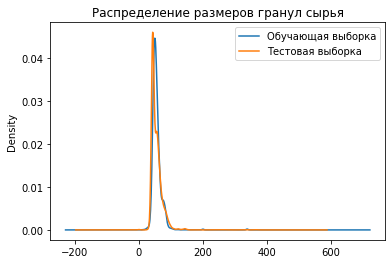

In [41]:
granules.plot.kde()
plt.title('Распределение размеров гранул сырья')
plt.legend(['Обучающая выборка', 'Тестовая выборка'])
plt.show() 

**Распределения близки друг к другу, следовательно, размеры гранул на обучающей и тестовой выборках отличаются минимально.**

### Исследуем суммарные концентрации

**Список стадий**

In [42]:
STAGES = ['rougher.input.feed', 'rougher.output.concentrate', 'final.output.concentrate']

**Список елементов**

In [43]:
ELEMENTS = ['au', 'pb', 'ag', 'sol']

**Создадим датафрейм с суммарными концентрациями елементов для каждой стадии**

In [44]:
def get_elements_sum(df_train):
    
    elements_sum = pd.DataFrame()

    for stage in STAGES:
        elements_sum[stage] = df_train[map(lambda item: stage + '_' + item, ELEMENTS)].sum(axis=1)
    return elements_sum

In [45]:
elements_sum = get_elements_sum(df_train)
elements_sum.head()

,rougher.input.feed,rougher.output.concentrate,final.output.concentrate
0,51.6800,66.4249,63.6444
1,50.6591,67.0127,63.9577
2,50.6099,66.1038,64.3112
3,51.0615,65.7528,63.5734
4,47.8592,65.9084,64.0047


**Отобразим на графике**

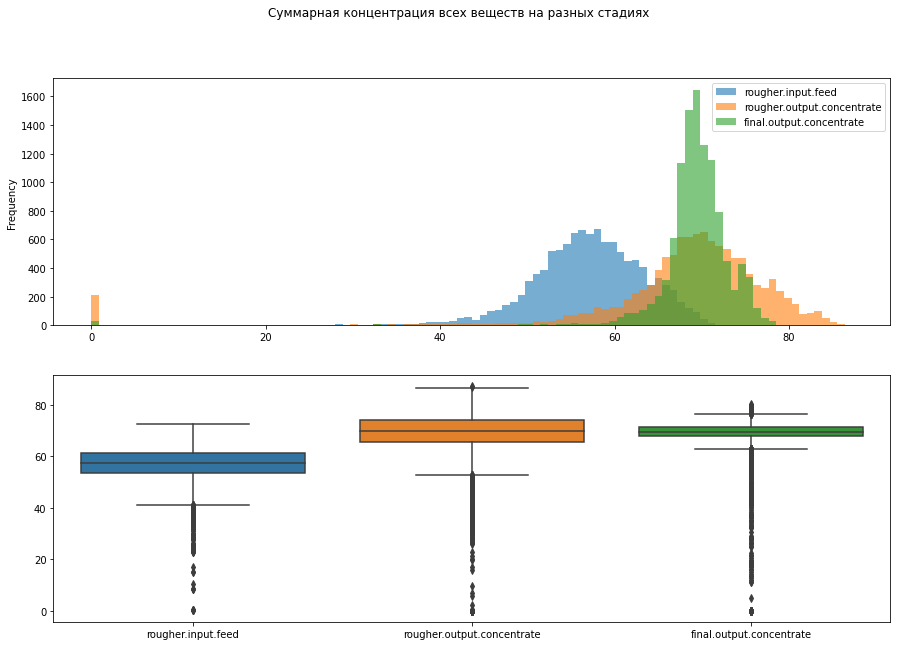

In [46]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
elements_sum.plot.hist(bins=100, alpha=0.6, ax=axes[0])
sns.boxplot(data=elements_sum, ax=axes[1])
plt.suptitle('Суммарная концентрация всех веществ на разных стадиях')
plt.show() 

**Посчитаем процент выбросов**

In [47]:
for i in elements_sum.columns:
    z = np.abs(st.zscore(elements_sum[i]))
    outliners = elements_sum[i].iloc[np.where(z > 3)].count() / elements_sum[i].shape[0]
    print(f'\nПроцент выбросов в {i} равен: {outliners:.2%}')


Процент выбросов в rougher.input.feed равен: 0.90%

Процент выбросов в rougher.output.concentrate равен: 2.17%

Процент выбросов в final.output.concentrate равен: 1.23%


**Попробуем избавится от выбросов**

**Опишем функцию (фильтр Хампеля), которая заменяет на NaN все значения, у которых разница с медианой больше, чем пять медианных абсолютных отклонений (std)**

In [48]:
def hampel(vals_orig):
    vals = vals_orig.copy()    
    difference = np.abs(vals.median()-vals)
    median_abs_deviation = difference.median()
    threshold = 5 * median_abs_deviation
    outlier_idx = difference > threshold
    vals[outlier_idx] = np.nan
    return(vals)

In [49]:
for stage in STAGES:
    column = list(map(lambda item: stage + '_' + item, ELEMENTS))
    df_train[column] = hampel(df_train[column])

In [50]:
df_train.isna().sum().sort_values(ascending=False)

rougher.output.concentrate_sol                        399
final.output.concentrate_au                           397
rougher.output.concentrate_au                         346
rougher.output.concentrate_pb                         280
rougher.output.concentrate_ag                         237
final.output.concentrate_sol                          229
rougher.input.feed_sol                                198
final.output.concentrate_ag                           186
final.output.concentrate_pb                           110
rougher.input.feed_au                                   9
rougher.input.feed_ag                                   9
rougher.input.feed_pb                                   2
rougher.state.floatbank10_e_level                       0
rougher.state.floatbank10_e_air                         0
rougher.state.floatbank10_d_level                       0
rougher.state.floatbank10_d_air                         0
rougher.state.floatbank10_c_level                       0
rougher.state.

In [51]:
df_train.dropna(inplace=True)

In [52]:
elements_sum = get_elements_sum(df_train)
elements_sum.describe()

,rougher.input.feed,rougher.output.concentrate,final.output.concentrate
count,"9,788.0000","9,788.0000","9,788.0000"
mean,57.5237,69.8923,69.7692
std,5.6759,6.3469,2.7615
min,36.0065,42.7905,56.1487
25%,53.6595,66.1970,68.1184
50%,57.5018,70.0012,69.5750
75%,61.6039,74.0443,71.3424
max,72.4922,86.9950,77.3466


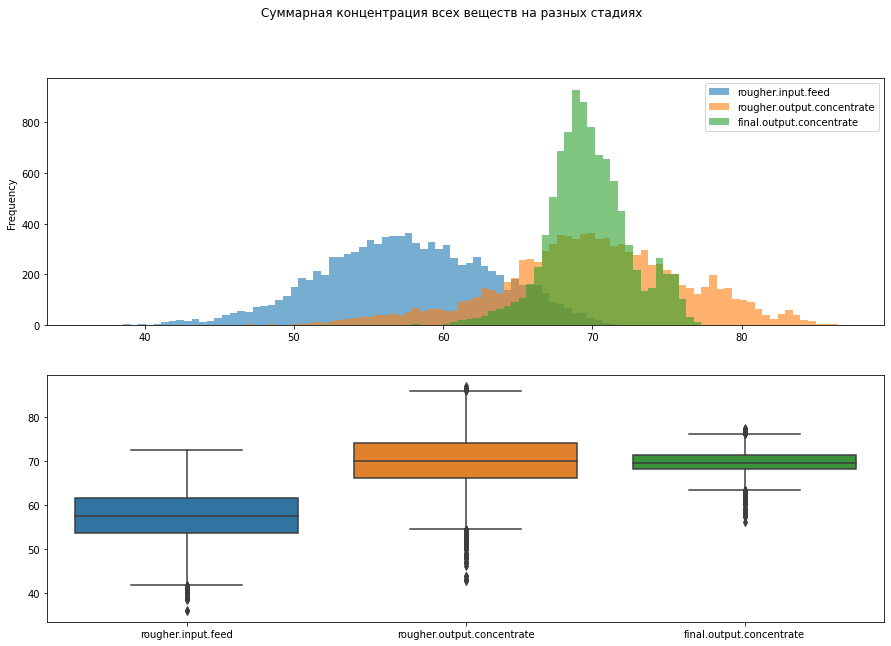

In [53]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
elements_sum.plot.hist(bins=100, alpha=0.6, ax=axes[0])
sns.boxplot(data=elements_sum, ax=axes[1])
plt.suptitle('Суммарная концентрация всех веществ на разных стадиях')
plt.show() 

**Вывод:**  
- На графиках для каждой стадии наблюдаются выбросы значений. В процентном сооотнешении от общего числа данных, выбросы составляют не больше 2%

## Модель

### Напишем функцию для вычисления итогового *sMAPE*

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mspace linebreak="newline"></mspace>
  <mi>s</mi>
  <mi>M</mi>
  <mi>A</mi>
  <mi>P</mi>
  <mi>E</mi>
  <mo>=</mo>
  <mfrac>
    <mn>1</mn>
    <mi>N</mi>
  </mfrac>
  <munderover>
    <mo data-mjx-texclass="OP">&#x2211;</mo>
    <mrow data-mjx-texclass="ORD">
      <mi>i</mi>
      <mo>=</mo>
      <mn>1</mn>
    </mrow>
    <mrow data-mjx-texclass="ORD">
      <mi>N</mi>
    </mrow>
  </munderover>
  <mo>&#x2217;</mo>
  <mfrac>
    <mrow>
      <mo data-mjx-texclass="ORD" stretchy="false">|</mo>
      <msub>
        <mi>y</mi>
        <mrow data-mjx-texclass="ORD">
          <mi>i</mi>
        </mrow>
      </msub>
      <mo>&#x2212;</mo>
      <mrow data-mjx-texclass="ORD">
        <mover>
          <mi>y</mi>
          <mo stretchy="false">^</mo>
        </mover>
      </mrow>
      <mo data-mjx-texclass="ORD" stretchy="false">|</mo>
    </mrow>
    <mrow>
      <mo stretchy="false">(</mo>
      <mo data-mjx-texclass="ORD" stretchy="false">|</mo>
      <msub>
        <mi>y</mi>
        <mrow data-mjx-texclass="ORD">
          <mi>i</mi>
        </mrow>
      </msub>
      <mo data-mjx-texclass="ORD" stretchy="false">|</mo>
      <mo>+</mo>
      <mo data-mjx-texclass="ORD" stretchy="false">|</mo>
      <mrow data-mjx-texclass="ORD">
        <mover>
          <mi>y</mi>
          <mo stretchy="false">^</mo>
        </mover>
      </mrow>
      <mo data-mjx-texclass="ORD" stretchy="false">|</mo>
      <mo stretchy="false">)</mo>
      <mrow data-mjx-texclass="ORD">
        <mo>/</mo>
      </mrow>
      <mn>2</mn>
    </mrow>
  </mfrac>
  <mo>&#x2217;</mo>
  <mn>100</mn>
  <mi mathvariant="normal">%</mi>
</math>

In [99]:
def sMAPE(target, prediction):
    return 1 / len(target) * sum( abs(target - prediction) / ( (abs(target) + abs(prediction)) * 0.5) ) * 100

<math xmlns="http://www.w3.org/1998/Math/MathML" display="block">
  <mspace linebreak="newline"></mspace>
  <mi>f</mi>
  <mi>i</mi>
  <mi>n</mi>
  <mi>a</mi>
  <mi>l</mi>
  <mo>=</mo>
  <mn>25</mn>
  <mi mathvariant="normal">%</mi>
  <mo>&#x2217;</mo>
  <mi>s</mi>
  <mi>M</mi>
  <mi>A</mi>
  <mi>P</mi>
  <mi>E</mi>
  <mo stretchy="false">(</mo>
  <mi>r</mi>
  <mi>o</mi>
  <mi>u</mi>
  <mi>g</mi>
  <mi>h</mi>
  <mi>e</mi>
  <mi>r</mi>
  <mo stretchy="false">)</mo>
  <mo>+</mo>
  <mn>75</mn>
  <mi mathvariant="normal">%</mi>
  <mo>&#x2217;</mo>
  <mi>s</mi>
  <mi>M</mi>
  <mi>A</mi>
  <mi>P</mi>
  <mi>E</mi>
  <mo stretchy="false">(</mo>
  <mi>f</mi>
  <mi>i</mi>
  <mi>n</mi>
  <mi>a</mi>
  <mi>l</mi>
  <mo stretchy="false">)</mo>
</math>

In [100]:
def sMAPE_final(rough, final):
    return 0.25 * rough + 0.75 * final

In [101]:
custom_score = make_scorer(sMAPE, greater_is_better=False)

### Обучим и проверим несколько моделей

**Так как столбцы в тестовой и обучающей выборках различаются, необходимо сформировать новую обучающую выборку только с теми столбцами, которые есть в тестовой**

In [57]:
df_train_full = df_train.copy()

df_train = df_train.drop(list(df_train.columns.difference(df_test.columns)), axis=1)

**Итоговая метрика sMAPE зависит линейно от sMAPE после флотации и после очистки, значит, обучать модель можно на двух независимых выборках Выделим в обучающей выборке признаки и целевые признаки. Сформируем списки столбцов для rougher и final выборок**

In [58]:
rougher_columns = []
pattern = re.compile('rougher')

for column in list(df_test.columns):
    if re.match(pattern, column):
        rougher_columns.append(column)

final_columns = list(set(df_test.columns) - set(rougher_columns))

In [59]:
test_index = list(df_test.index)

test_target_columns = pd.DataFrame()
test_target_columns = df_test.merge(df_full[['rougher.output.recovery', 'final.output.recovery', 'date']],
                         how = 'inner', on= 'date')

**Разделим выборки**

In [60]:
rougher_train_features = df_train[rougher_columns]
rougher_train_target = df_train_full['rougher.output.recovery']

final_train_features = df_train[final_columns]
final_train_target = df_train_full['final.output.recovery']

rougher_test_features = df_test[rougher_columns]
rougher_test_target = test_target_columns['rougher.output.recovery']

final_test_features = df_test[final_columns]
final_test_target = test_target_columns['final.output.recovery']

In [61]:
print(rougher_train_features.shape, rougher_train_target.shape)
print(final_train_features.shape, final_train_target.shape)
print(rougher_test_features.shape, final_test_features.shape)

(9788, 22) (9788,)
(9788, 31) (9788,)
(5229, 22) (5229, 31)


In [62]:
final_train_features.drop(['date'], axis=1, inplace=True)
final_test_features.drop(['date'], axis=1, inplace=True)

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


**Масштабируем признаки на обучающей и тестовой выборках с помощью метода StandardScaler**

In [63]:
scaler_rougher = StandardScaler()
scaler_final = StandardScaler()

In [64]:
rougher_train_features = scaler_rougher.fit_transform(rougher_train_features)
rougher_test_features = scaler_rougher.transform(rougher_test_features)

In [65]:
final_train_features = scaler_final.fit_transform(final_train_features)
final_test_features = scaler_final.transform(final_test_features)

**Создадим модели CatBoostRegressor и DecisionTreeRegressor**

In [66]:
model_cb = CatBoostRegressor(random_state=42)
model_dt = DecisionTreeRegressor(random_state=42)

**Зададим параметры для GridSearchCV**

In [67]:
parameters_cb = {'depth': [3, 7, 9], 'logging_level':['Silent']}
parameters_dt = {'max_depth':[1,10]}

In [68]:
def get_grid(model, parameters, custom_score, features, target):
    grid = GridSearchCV(model, parameters, custom_score)
    grid.fit(features, target)
    return grid

In [69]:
grid_rougher_cb = get_grid(model_cb, parameters_cb, custom_score, rougher_train_features, rougher_train_target)
grid_rougher_dt = get_grid(model_dt, parameters_dt, custom_score, rougher_train_features, rougher_train_target)

grid_final_cb = get_grid(model_cb, parameters_cb, custom_score, final_train_features, final_train_target)
grid_final_dt = get_grid(model_dt, parameters_dt, custom_score, final_train_features, final_train_target)

/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass scoring=make_scorer(sMAPE, greater_is_better=False) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass scoring=make_scorer(sMAPE, greater_is_better=False) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass scoring=make_scorer(sMAPE, greater_is_better=False) as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "
/opt/conda/lib/python3.9/sit

**Выведем параметры обученных моделей**

In [70]:
def display_grid(grid):
    print('Best score:', grid.best_score_, 
          '\nBest estimator:', grid.best_estimator_)

In [71]:
display_grid(grid_rougher_cb)

Best score: -5.997289006321408 
Best estimator: <catboost.core.CatBoostRegressor object at 0x7f1e336cf3a0>


In [72]:
display_grid(grid_rougher_dt)

Best score: -6.626182024387916 
Best estimator: DecisionTreeRegressor(max_depth=1, random_state=42)


In [73]:
display_grid(grid_final_cb)

Best score: -9.255599074069854 
Best estimator: <catboost.core.CatBoostRegressor object at 0x7f1e322fcaf0>


In [74]:
display_grid(grid_final_dt)

Best score: -8.895447513105546 
Best estimator: DecisionTreeRegressor(max_depth=1, random_state=42)


**Очевидно, лучшие параметры показывает CatBoostRegressor**

**Рассчитаем итоговую sMAPE**

In [75]:
sMAPE_final(grid_rougher_cb.best_score_, grid_final_cb.best_score_)

-8.441021557132743

In [76]:
sMAPE_final(grid_rougher_dt.best_score_, grid_final_dt.best_score_)

-8.32813114092614

**Опять же, у RandomForestRegressor результат лучше**

### Выбрем лучшую модель, её качество проверим на тестовой выборке

In [77]:
rougher_test_predictions = grid_rougher_cb.predict(rougher_test_features)

In [78]:
final_test_predictions = grid_final_cb.predict(final_test_features)

In [79]:
sMAPE_final(sMAPE(rougher_test_target, rougher_test_predictions),
            sMAPE(final_test_target, final_test_predictions))

9.992161896131014

**DummyRegressor**

In [102]:
strategies = ['mean', 'median', 'quantile', 'constant']
for strategy in strategies:
    model_for_rouger = DummyRegressor()
    model_for_final = DummyRegressor()
    
    model_for_rouger.fit(rougher_train_features, rougher_train_target)
    model_for_final.fit(final_train_features, final_train_target)
    
    model_for_rouger_pred = model_for_rouger.predict(rougher_test_features)
    model_for_final_pred = model_for_final.predict(final_test_features)

    result = sMAPE_final(sMAPE(rougher_test_target, model_for_rouger_pred),sMAPE(final_test_target, model_for_final_pred))
    
    #result = model.make_scorer(sMAPE(rougher_test_features, rougher_test_target))
    print(f'{strategy} = {result}')

mean = 9.231465117397892
median = 9.231465117397892
quantile = 9.231465117397892
constant = 9.231465117397892


**Результаты `обученных моделей` на `тестовой выборке` показали результат выше, чем результаты `DummyClassifier`. Это даёт право сделать вывод, что модели проходят проверку на адекватность.**

**Вывод:**  

- Итоговая модель была построена на алгоритме CatBoostRegressor
- Ошибка модели на обучающей выборке 9.433
- sMAPE_final на тестовой выборке 12.066

## Чек-лист готовности проекта

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке выполнения
- [x]  Выполнен шаг 1: данные подготовлены
    - [x]  Проверена формула вычисления эффективности обогащения
    - [x]  Проанализированы признаки, недоступные в тестовой выборке
    - [x]  Проведена предобработка данных
- [x]  Выполнен шаг 2: данные проанализированы
    - [x]  Исследовано изменение концентрации элементов на каждом этапе
    - [x]  Проанализированы распределения размеров гранул на обучающей и тестовой выборках
    - [x]  Исследованы суммарные концентрации
- [x]  Выполнен шаг 3: построена модель прогнозирования
    - [x]  Написана функция для вычисления итогового *sMAPE*
    - [x]  Обучено и проверено несколько моделей
    - [x]  Выбрана лучшая модель, её качество проверено на тестовой выборке